In [1]:
import pandas as pd
import numpy as np
import pyproj
from scipy.spatial import KDTree
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Haversine formula to calculate distance between two latitude longitude points
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [3]:
trucks = pd.read_csv('../data/raw/trucks.csv')
trucks = trucks.drop(columns=['Unnamed: 0'])

In [4]:
beetloader = pd.read_csv('../data/processed/beetloader_processed.csv')

In [5]:

# change column names
column_names = {
    'A': 'A',
    'B': 'B',
    'C': 'C',
    'Datum Erstwägung': 'date',
    'Eingangswaagenzeit': 'time',
    'GPS Längengrad': 'longitude',
    'GPS Breitengrad': 'latitude'
}
trucks = trucks.rename(columns=column_names)
# connect date and time columns
trucks['datetime'] = pd.to_datetime(trucks['date'] + ' ' + trucks['time'], format='%m/%d/%Y %I:%M:%S %p')
trucks = trucks.sort_values(by=['datetime'])
beetloader = beetloader.sort_values(by=['takenat'])

In [6]:
# wybranie najnowszej wersji algorytmu
unique_algorithm_versions = beetloader['algorithmversion'].unique()
newest_version = sorted(unique_algorithm_versions, key=lambda v: tuple(map(int, v[1:].split('.'))), reverse=True)[0]
beetloader = beetloader[beetloader['algorithmversion'] == newest_version]

In [7]:
trucks['date'] = pd.to_datetime(trucks['date'], format='%m/%d/%Y')

In [8]:
# find unique dates in beetloader and trucks
unique_dates_beetloader = set(beetloader['takenat'].apply(lambda x: pd.to_datetime(x).date()))
unique_dates_trucks = set(trucks['datetime'].apply(lambda x: pd.to_datetime(x).date()))
common_dates = unique_dates_beetloader.intersection(unique_dates_trucks)

In [9]:
# make datasets with common dates
filtered_beetloader = beetloader[beetloader['takenat'].apply(lambda x: pd.to_datetime(x).date() in common_dates)]
filtered_trucks = trucks[trucks['datetime'].apply(lambda x: pd.to_datetime(x).date() in common_dates)]

In [10]:
# filter beetloader dataset to 200m distance for all unique points in trucks
trucks_coords = filtered_trucks[['latitude', 'longitude']].drop_duplicates(subset=['latitude', 'longitude']).values
tree = KDTree(trucks_coords)
beetloader_points = filtered_beetloader[['latitude', 'longitude']].values
points_found = tree.query_ball_point(beetloader_points, 0.0025)
filtered_beetloader = filtered_beetloader[[bool(i) for i in points_found]]
# filtered_beetloader select only false in beetloader_empty_belt
filtered_beetloader = filtered_beetloader[filtered_beetloader['beetloader_empty_belt'] == False]


In [11]:
filtered_beetloader['takenat'] = pd.to_datetime(beetloader['takenat'])

In [12]:
eval_list = []
for point_date, lat, lng in filtered_trucks[['date', 'latitude', 'longitude']].drop_duplicates().values:
    # print(points)
    df_trucks = filtered_trucks[(filtered_trucks['date'] == point_date) & (filtered_trucks['latitude'] == lat) & (filtered_trucks['longitude'] == lng)]
    df_beetloader = filtered_beetloader[filtered_beetloader.apply(lambda row: haversine_distance(lat, lng, row['latitude'], row['longitude']) <= 200, axis=1)]
    df_beetloader = df_beetloader[df_beetloader['takenat'].dt.date == point_date]
    
    # obliczenie średniej ważonej dla kolumny a
    weighted_mean_A = (df_beetloader['beetloader_A'] * df_beetloader['beetloader_beet_count']).sum() / df_beetloader['beetloader_beet_count'].sum()    
    weighted_mean_A = round(weighted_mean_A, 2)
    # obliczenie średniej ważonej dla kolumny b
    weighted_mean_B = (df_beetloader['beetloader_B'] * df_beetloader['beetloader_beet_count']).sum() / df_beetloader['beetloader_beet_count'].sum()    
    weighted_mean_B = round(weighted_mean_B, 2)
    # obliczenie średniej ważonej dla kolumny c
    weighted_mean_C = (df_beetloader['beetloader_C'] * df_beetloader['beetloader_beet_count']).sum() / df_beetloader['beetloader_beet_count'].sum()    
    weighted_mean_C = round(weighted_mean_C, 2)

    eval_dict = {
        'date': point_date,
        'trucks_count': df_trucks.shape[0],
        'latitude': lat,
        'longitude': lng,
        'beetloader_A': weighted_mean_A,
        'beetloader_B': weighted_mean_B,
        'beetloader_C': weighted_mean_C,
        'beetloader_beet_count': df_beetloader['beetloader_beet_count'].sum(),
        'trucks_A': df_trucks['A'].mean(),
        'trucks_B': df_trucks['B'].mean(),
        'trucks_C': df_trucks['C'].mean(),
        'time_start': df_beetloader['takenat'].min(),
        'time_end': df_beetloader['takenat'].max(),
    }
    eval_list.append(eval_dict)
    



In [13]:
eval_df = pd.DataFrame(eval_list)

### Evaluated model dataset

In [14]:
eval_df

,date,trucks_count,latitude,longitude,beetloader_A,beetloader_B,beetloader_C,beetloader_beet_count,trucks_A,trucks_B,trucks_C,time_start,time_end
0,2022-10-20,9,51.009888,6.036406,3.02,0.52,4.48,2821.0,2.9,0.0,4.000000,2022-10-20 04:33:07.007,2022-10-20 04:49:27.294
1,2022-10-20,5,51.011807,6.025018,2.98,0.55,4.44,4787.0,2.9,0.0,4.250000,2022-10-20 05:09:37.366,2022-10-20 06:11:07.609
2,2022-10-20,18,51.005714,6.043033,2.97,0.42,3.92,5179.0,2.9,0.0,4.764444,2022-10-20 11:57:06.162,2022-10-20 12:57:05.219
3,2022-12-06,4,51.017178,6.018067,3.03,0.70,3.88,1717.0,2.9,0.0,6.000000,2022-12-06 19:18:16.293,2022-12-06 19:43:36.823
4,2022-12-07,2,51.017178,6.018067,3.02,0.68,4.24,800.0,2.9,0.0,4.000000,2022-12-07 04:46:18.074,2022-12-07 04:59:08.227


In [15]:
eval_df['difference_A'] = eval_df['beetloader_A']  - eval_df['trucks_A'] # wartość ujemna - strata % stakeholders, wartość dodatnia strata % plantatora
eval_df['difference_B'] = eval_df['beetloader_B'] - eval_df['trucks_B']
eval_df['difference_C'] = eval_df['beetloader_C'] - eval_df['trucks_C']
eval_df['t_stat_A'], eval_df['p_value_A'] = ttest_ind(eval_df['trucks_A'], eval_df['beetloader_A'])
eval_df['t_stat_B'], eval_df['p_value_B'] = ttest_ind(eval_df['trucks_B'], eval_df['beetloader_B'])
eval_df['t_stat_C'], eval_df['p_value_C'] = ttest_ind(eval_df['trucks_C'], eval_df['beetloader_C'])


In [16]:
eval_df

,date,trucks_count,latitude,longitude,beetloader_A,beetloader_B,beetloader_C,beetloader_beet_count,trucks_A,trucks_B,...,time_end,difference_A,difference_B,difference_C,t_stat_A,p_value_A,t_stat_B,p_value_B,t_stat_C,p_value_C
0,2022-10-20,9,51.009888,6.036406,3.02,0.52,4.48,2821.0,2.9,0.0,...,2022-10-20 04:49:27.294,0.12,0.52,0.480000,-8.607101,0.000026,-11.014049,0.000004,1.035741,0.330614
1,2022-10-20,5,51.011807,6.025018,2.98,0.55,4.44,4787.0,2.9,0.0,...,2022-10-20 06:11:07.609,0.08,0.55,0.190000,-8.607101,0.000026,-11.014049,0.000004,1.035741,0.330614
2,2022-10-20,18,51.005714,6.043033,2.97,0.42,3.92,5179.0,2.9,0.0,...,2022-10-20 12:57:05.219,0.07,0.42,-0.844444,-8.607101,0.000026,-11.014049,0.000004,1.035741,0.330614
3,2022-12-06,4,51.017178,6.018067,3.03,0.70,3.88,1717.0,2.9,0.0,...,2022-12-06 19:43:36.823,0.13,0.70,-2.120000,-8.607101,0.000026,-11.014049,0.000004,1.035741,0.330614
4,2022-12-07,2,51.017178,6.018067,3.02,0.68,4.24,800.0,2.9,0.0,...,2022-12-07 04:59:08.227,0.12,0.68,0.240000,-8.607101,0.000026,-11.014049,0.000004,1.035741,0.330614


### Check if difference between model and trucks is corelated with beetloader_beet_count value

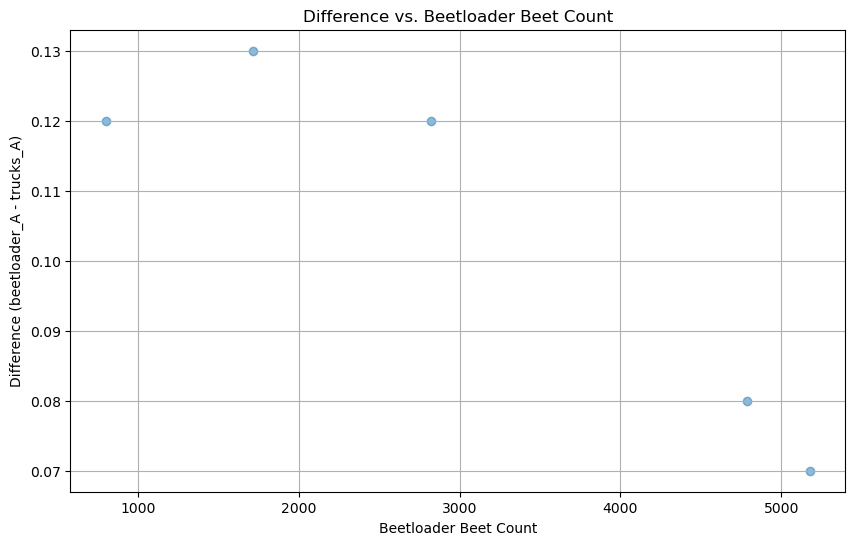

-0.9174465330760508

In [17]:
correlation = eval_df['difference_A'].corr(eval_df['beetloader_beet_count'])

# Visualize the relationship using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(eval_df['beetloader_beet_count'], eval_df['difference_A'], alpha=0.5)
plt.title('Difference vs. Beetloader Beet Count')
plt.xlabel('Beetloader Beet Count')
plt.ylabel('Difference (beetloader_A - trucks_A)')
plt.grid(True)
plt.show()

correlation


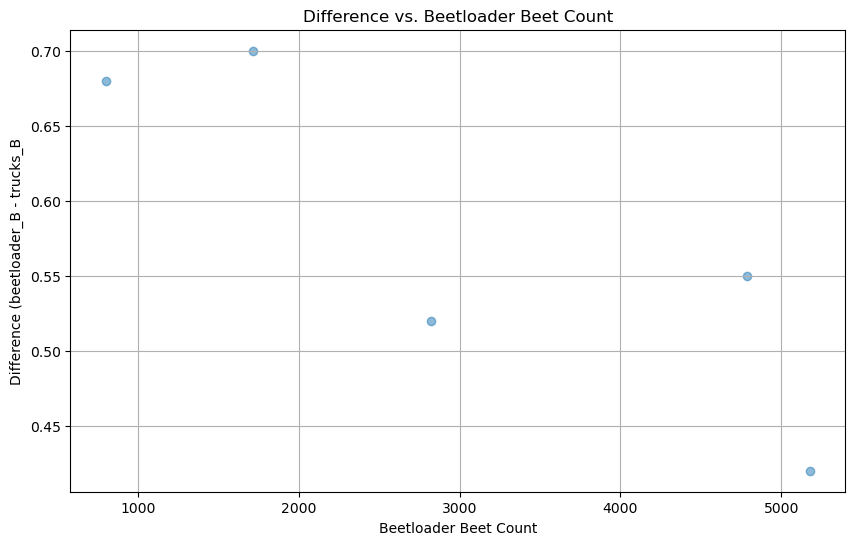

-0.8622093190206743

In [18]:
correlation = eval_df['difference_B'].corr(eval_df['beetloader_beet_count'])

# Visualize the relationship using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(eval_df['beetloader_beet_count'], eval_df['difference_B'], alpha=0.5)
plt.title('Difference vs. Beetloader Beet Count')
plt.xlabel('Beetloader Beet Count')
plt.ylabel('Difference (beetloader_B - trucks_B')
plt.grid(True)
plt.show()

correlation


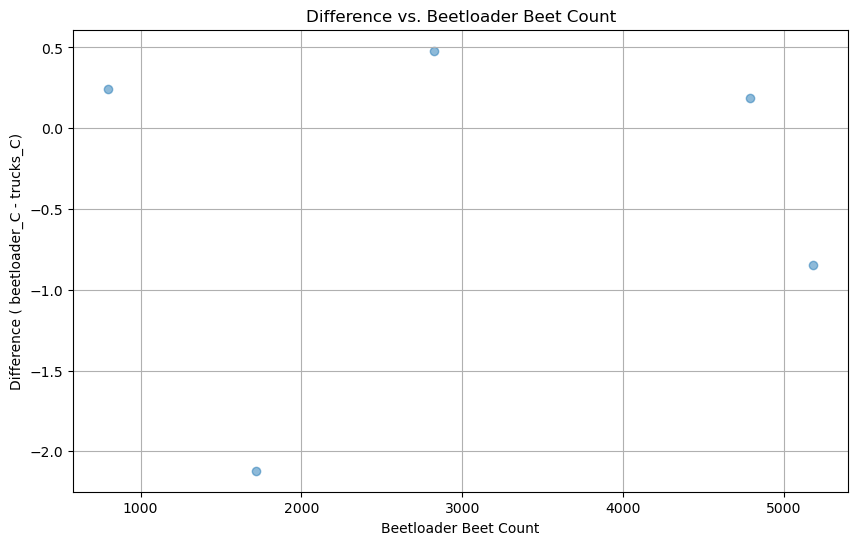

0.0887799262587512

In [20]:
correlation = eval_df['difference_C'].corr(eval_df['beetloader_beet_count'])

# Visualize the relationship using a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(eval_df['beetloader_beet_count'], eval_df['difference_C'], alpha=0.5)
plt.title('Difference vs. Beetloader Beet Count')
plt.xlabel('Beetloader Beet Count')
plt.ylabel('Difference ( beetloader_C - trucks_C)')
plt.grid(True)
plt.show()

correlation
